In [1]:
#import SparkSession
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
6,application_1589383180073_0007,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
spark=SparkSession.builder.appName('bigdata-project').getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
#Cargamos los datasets desde el bucket S3
df_confirmed=spark.read.csv('s3://fcortesj-eafit-20201/covid_datasets/global/confirmados/time_series_covid19_confirmed_global_narrow.csv',inferSchema=True,header=True)
df_deaths=spark.read.csv('s3://fcortesj-eafit-20201/covid_datasets/global/muertes/time_series_covid19_deaths_global_narrow.csv',inferSchema=True,header=True)
df_recovered=spark.read.csv('s3://fcortesj-eafit-20201/covid_datasets/global/recuperados/time_series_covid19_recovered_global_narrow.csv',inferSchema=True,header=True)
df_colombia=spark.read.csv('s3://fcortesj-eafit-20201/covid_datasets/colombia/data.csv',inferSchema=True,header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
#Instalar paquetes necesarios
sc.install_pypi_package('pandas')
sc.install_pypi_package('matplotlib')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl (10.0 MB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)

  Using cached matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached kiwisolver-1.2.0-cp36-cp36m-manylinux1_x86_64.whl (88 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

In [5]:
#Importamos los modulos necesarios
from pyspark.sql import functions as f
from pyspark.sql.functions import col, max as max_
import matplotlib.pyplot as plt
import numpy as np

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
#Data Preparation (Manipulacion y preparacion de datos)

print('Observaremos las dos estructuras de los dataframes de ambos data sets:')
print('Primero el global')
df_confirmed.show(7)

print('Luego el de Colombia')
df_colombia.show(7)

print('Podemos observar que los dataframes no son iguales y muchos de los datos que se enuncian no los necesitaremos, por lo cual hay que tratar los datos para poder extraer lo que necesitamos:')
print('Los datos que necesitarems en este caso son el numero de infectados en cuestion de tiempo, ya que el resto de datos se volverian atipicos al comparar entre si los datasets. Por lo que seria necesario la fecha e los infectados: ')
print('Empezaremos con el dataset Global:')
df_confirmed_selected = df_confirmed.withColumn("Value", col("Value").cast("int")).groupBy("Date").agg(max_("Value")).orderBy('max(Value)',ascending=True)
df_confirmed_selected.show()
print('Podemos observar como el nuevo dataset tiene los datos que nos interesan, que son el numero de infectados por fecha. Ahora vamos con el dataset de Colombia')
df_colombia_selected = df_colombia.groupBy('Fecha diagnostico').count()
df_colombia_selected.show()
print('En este segundo dataframe nuevo podemos ver varios problemas, como por ejemplo la fecha esta en diferente formato a la fecha del anterior dataframe. Lo cual debe ser igual. Y el segundo problema es que se registran casos concretos en cada fecha pero lo que nos importa es el acomulado. Por loq eu hay que hacer las siguientes transformaciones')
acum = 0
x2 = df_colombia_selected.toPandas()['Fecha diagnostico'].values.tolist()
y2 = df_colombia_selected.toPandas()['count'].values.tolist()

for e in range(len(y2)):
    x2[e] = x2[e][0:10] 
    acum += y2[e]
    y2[e] = acum

df_colombia_transformed = sqlContext.createDataFrame(zip(x2, y2), schema=['Date', 'Infected'])
df_colombia_transformed.show()

print('Ahora podemos observar que ambos dataframes tienen la misma estructura y estan listos para ser graficados. Por cuestiones educativas estas transformaciones estan embebidas antes de cada grafica, por lo que esta seccion se hizo para evidenciar como se hace la tranformacion y data management')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Observaremos las dos estructuras de los dataframes de ambos data sets:
Primero el global
+--------------+--------------+--------+--------+----------+--------------------+------------------------+-----------------+----------------+------------------------+
|Province/State|Country/Region|     Lat|    Long|      Date|               Value|ISO 3166-1 Alpha 3-Codes|      Region Code| Sub-region Code|Intermediate Region Code|
+--------------+--------------+--------+--------+----------+--------------------+------------------------+-----------------+----------------+------------------------+
|    #adm1+name| #country+name|#geo+lat|#geo+lon|     #date|#affected+infecte...|           #country+code|#region+main+code|#region+sub+code|    #region+intermedi...|
|          null|   Afghanistan|    33.0|    65.0|2020-05-06|                3392|                     AFG|              142|              34|                    null|
|          null|   Afghanistan|    33.0|    65.0|2020-05-05|                

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

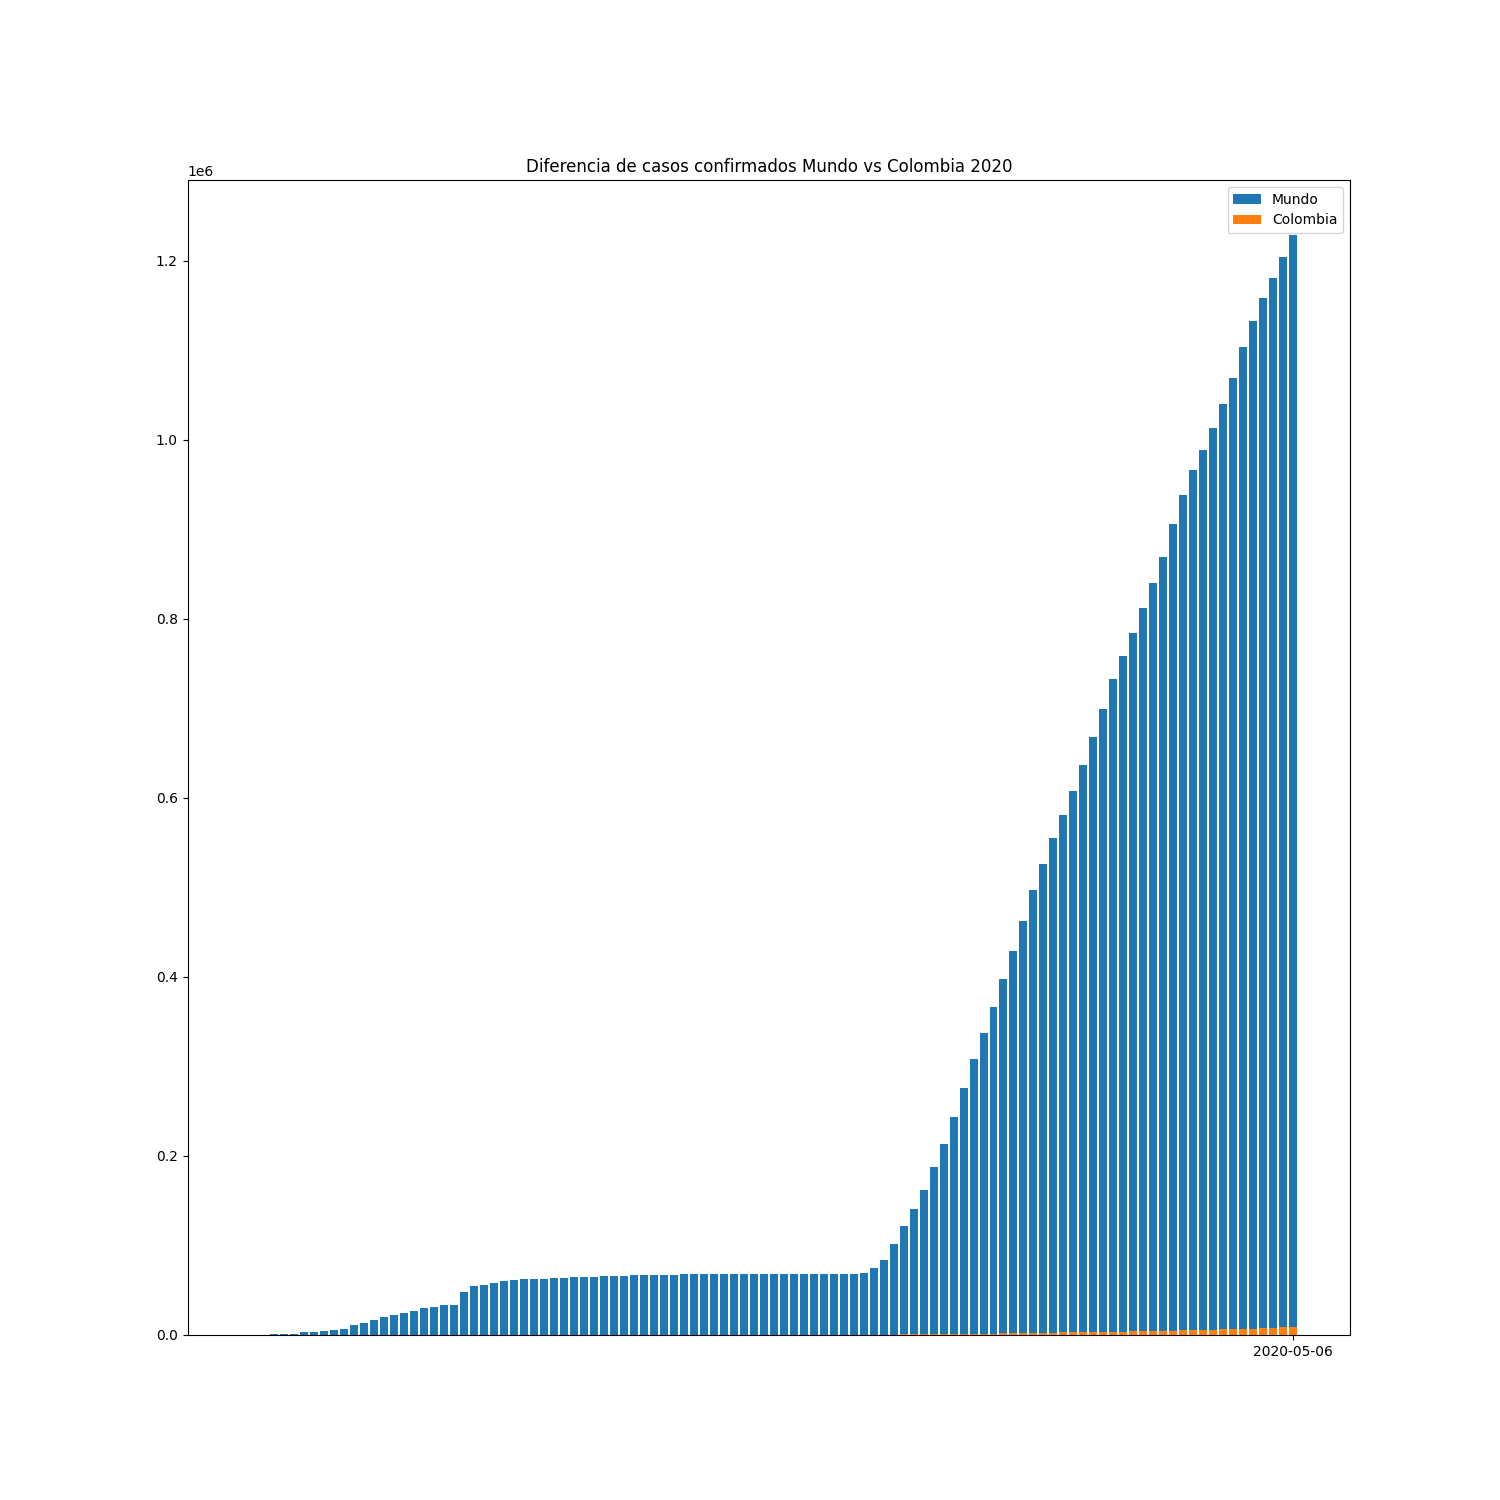

In [7]:
#Graficas comparativas del progreso de casos confirmados

fig3, ax3 = plt.subplots(figsize=(15,15))

progressCases = df_confirmed.withColumn("Value", col("Value").cast("int")).groupBy("Date").agg(max_("Value")).orderBy('max(Value)',ascending=True)
x = progressCases.toPandas()['Date'].values.tolist()
y = progressCases.toPandas()['max(Value)'].values.tolist()

acum = 0

infection_progress = df_colombia.groupBy('Fecha diagnostico').count().orderBy('Fecha diagnostico',ascending=True)
x2 = infection_progress.toPandas()['Fecha diagnostico'].values.tolist()
y2 = infection_progress.toPandas()['count'].values.tolist()

for e in range(len(y2)):
    x2[e] = x2[e][0:10] 
    acum += y2[e]
    y2[e] = acum

length = int(len(y))
temp_y_colombia = [0]*length

for e in range(len(x)):
    if x[e] in x2:
        ind = x2.index(x[e])
        temp_y_colombia[e] = y2[ind]
    else:
        temp_y_colombia[e] = 0
        
ax3.bar(x[1:],y[1:],label='Mundo')
ax3.bar(x[1:],temp_y_colombia[1:],label='Colombia')
ax3.set_xticks(x[-1:])
ax3.set_title('Diferencia de casos confirmados Mundo vs Colombia 2020')
ax3.legend(loc="upper right")

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

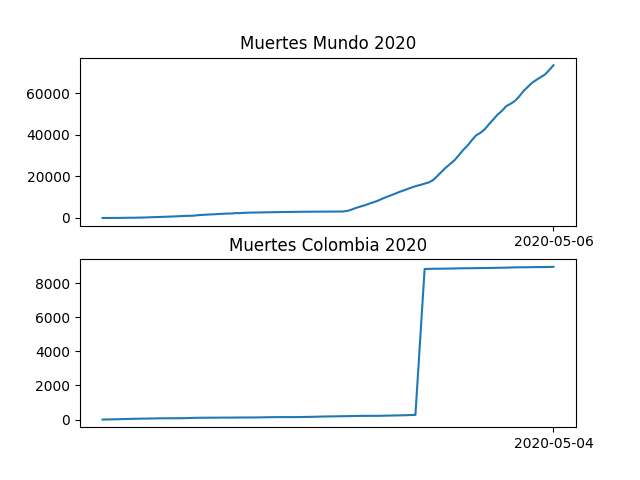

In [8]:
#Graficas comparativas del progreso de los casos de  muerte por COVID

fig, ax = plt.subplots(2)

progressCases = df_deaths.withColumn("Value", col("Value").cast("int")).groupBy("Date").agg(max_("Value")).orderBy('max(Value)',ascending=True)
x = progressCases.toPandas()['Date'].values.tolist()
y = progressCases.toPandas()['max(Value)'].values.tolist()

ax[0].plot(x[1:],y[1:])
ax[0].set_title('Muertes Mundo 2020')
ax[0].set_xticks(x[-1:])

acum = 0

infection_deaths = df_colombia.groupBy('Fecha de muerte').count()
x2 = infection_deaths.toPandas()['Fecha de muerte'].values.tolist()
y2 = infection_deaths.toPandas()['count'].values.tolist()

for e in range(len(y2)):
    if x2[e] is None:
        x2[e] = 'NA';
    else:
        x2[e] = x2[e][0:10]
    acum += y2[e]
    y2[e] = acum

ax[1].plot(x2,y2)
ax[1].set_title('Muertes Colombia 2020')
ax[1].set_xticks(x2[-1:])

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

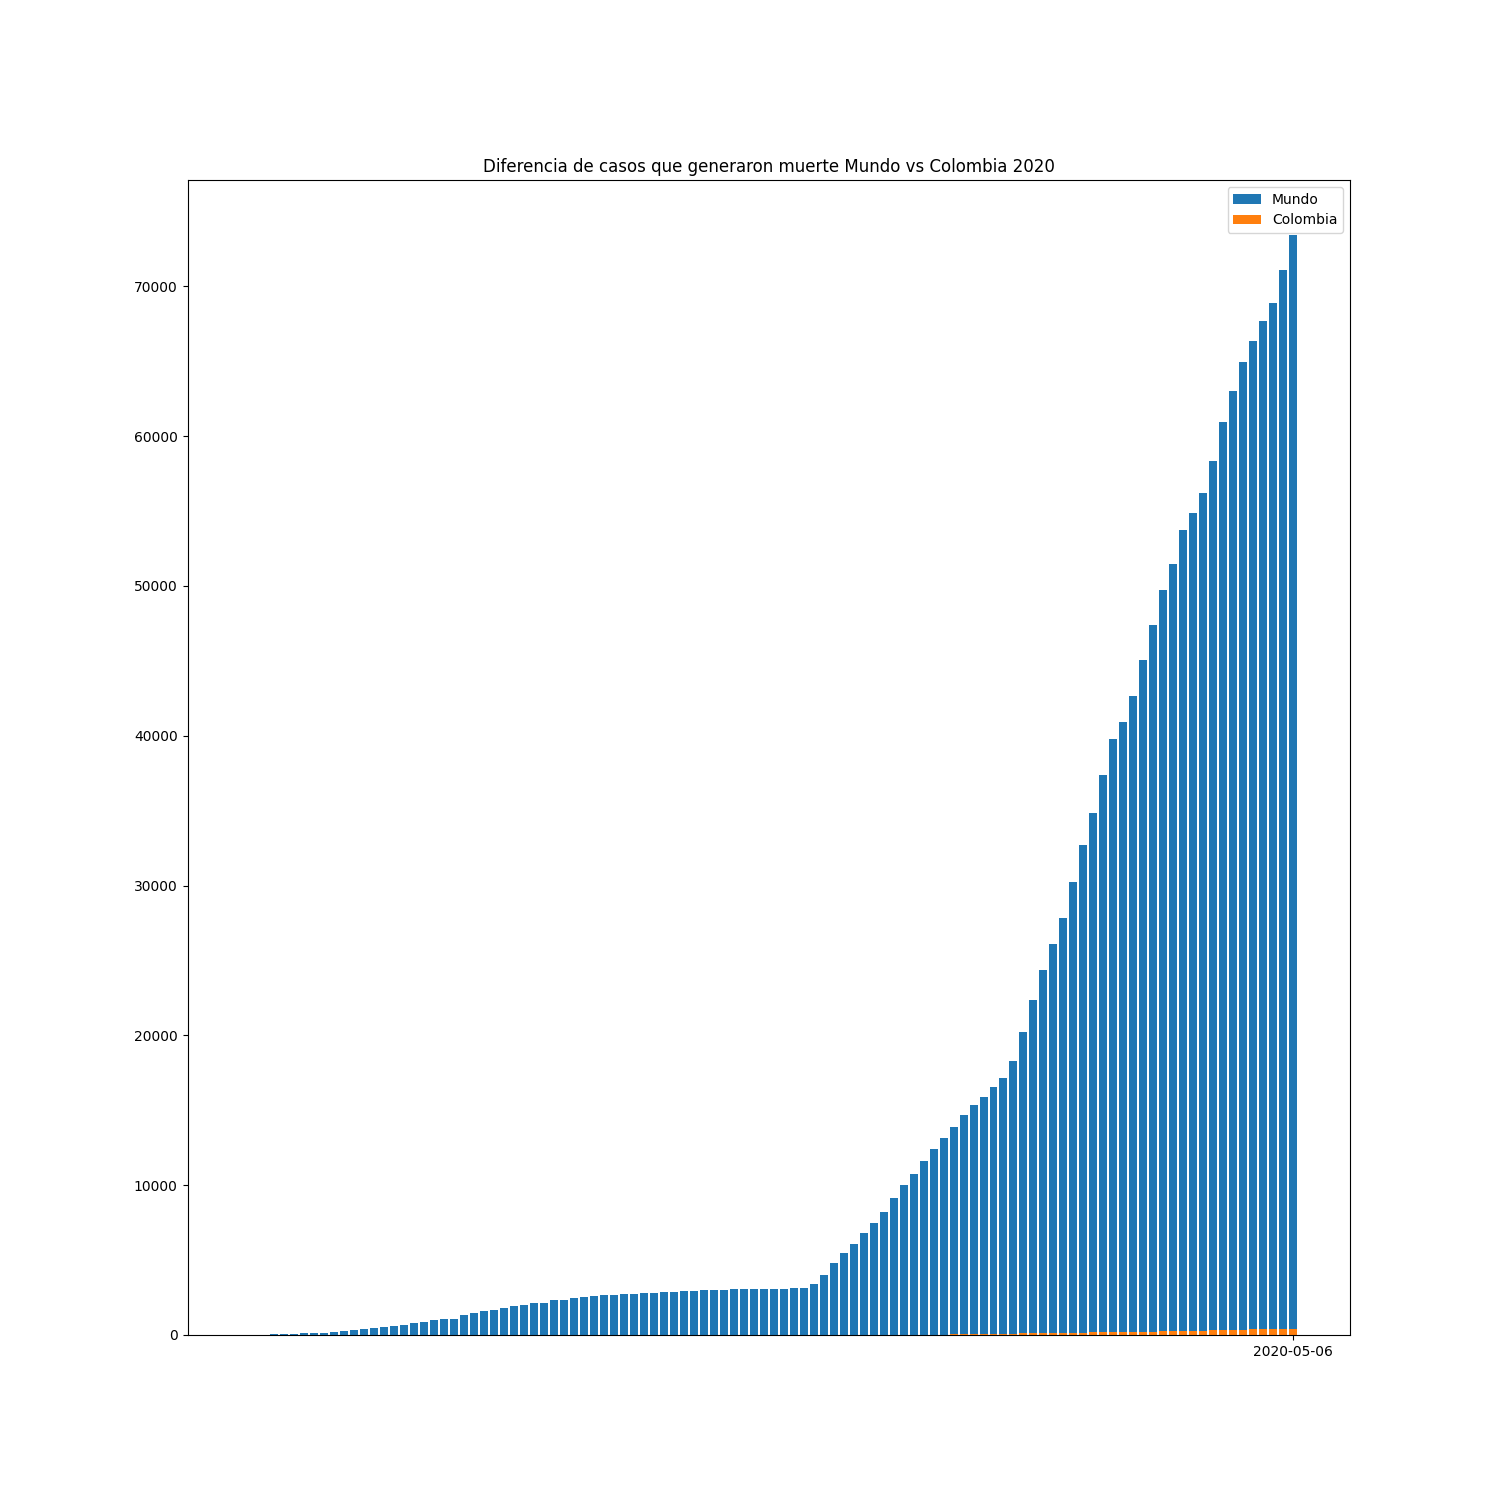

In [9]:
#Graficas comparativas del progreso de casos de muerte

fig4, ax4 = plt.subplots(figsize=(15,15))

progressCases = df_deaths.withColumn("Value", col("Value").cast("int")).groupBy("Date").agg(max_("Value")).orderBy('max(Value)',ascending=True)
x = progressCases.toPandas()['Date'].values.tolist()
y = progressCases.toPandas()['max(Value)'].values.tolist()

acum = 0

infection_progress = df_colombia.groupBy('Fecha de muerte').count().orderBy('Fecha de muerte',ascending=True)
x2 = infection_progress.toPandas()['Fecha de muerte'].values.tolist()
y2 = infection_progress.toPandas()['count'].values.tolist()

#Quitamos primeros datos atipicos
x2 = x2[3:]
y2 = y2[3:]

for e in range(len(y2)):
    if x2[e] is None:
        x2[e] = 'NA';
    else:
        x2[e] = x2[e][0:10]
    acum += y2[e]
    y2[e] = acum
    
length = int(len(y))
temp_y_colombia = [0]*length

for e in range(len(x)):
    if x[e] in x2:
        ind = x2.index(x[e])
        temp_y_colombia[e] = y2[ind]
    else:
        temp_y_colombia[e] = 0
        
ax4.bar(x[1:],y[1:],label='Mundo')
ax4.bar(x[1:],temp_y_colombia[1:],label='Colombia')
ax4.set_xticks(x[-1:])
ax4.set_title('Diferencia de casos que generaron muerte Mundo vs Colombia 2020')
ax4.legend(loc="upper right")

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

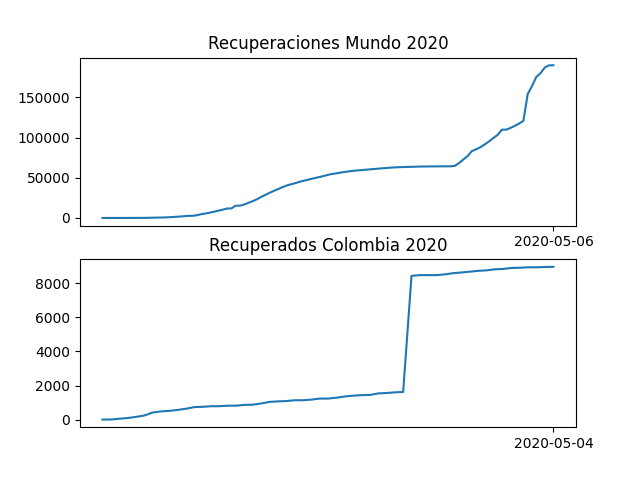

In [10]:
#Graficas comparativas del progreso de los casos de recuperacion por COVID

fig2, ax2 = plt.subplots(2)

progressCases = df_recovered.withColumn("Value", col("Value").cast("int")).groupBy("Date").agg(max_("Value")).orderBy('max(Value)',ascending=True)
x = progressCases.toPandas()['Date'].values.tolist()
y = progressCases.toPandas()['max(Value)'].values.tolist()

ax2[0].plot(x[1:],y[1:])
ax2[0].set_title('Recuperaciones Mundo 2020')
ax2[0].set_xticks(x[-1:])

acum = 0

infection_deaths = df_colombia.groupBy('Fecha recuperado').count()
x2 = infection_deaths.toPandas()['Fecha recuperado'].values.tolist()
y2 = infection_deaths.toPandas()['count'].values.tolist()

for e in range(len(y2)):
    if x2[e] is None:
        x2[e] = 'NA';
    else:
        x2[e] = x2[e][0:10]
    acum += y2[e]
    y2[e] = acum

ax2[1].plot(x2,y2)
ax2[1].set_title('Recuperados Colombia 2020')
ax2[1].set_xticks(x2[-1:])

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

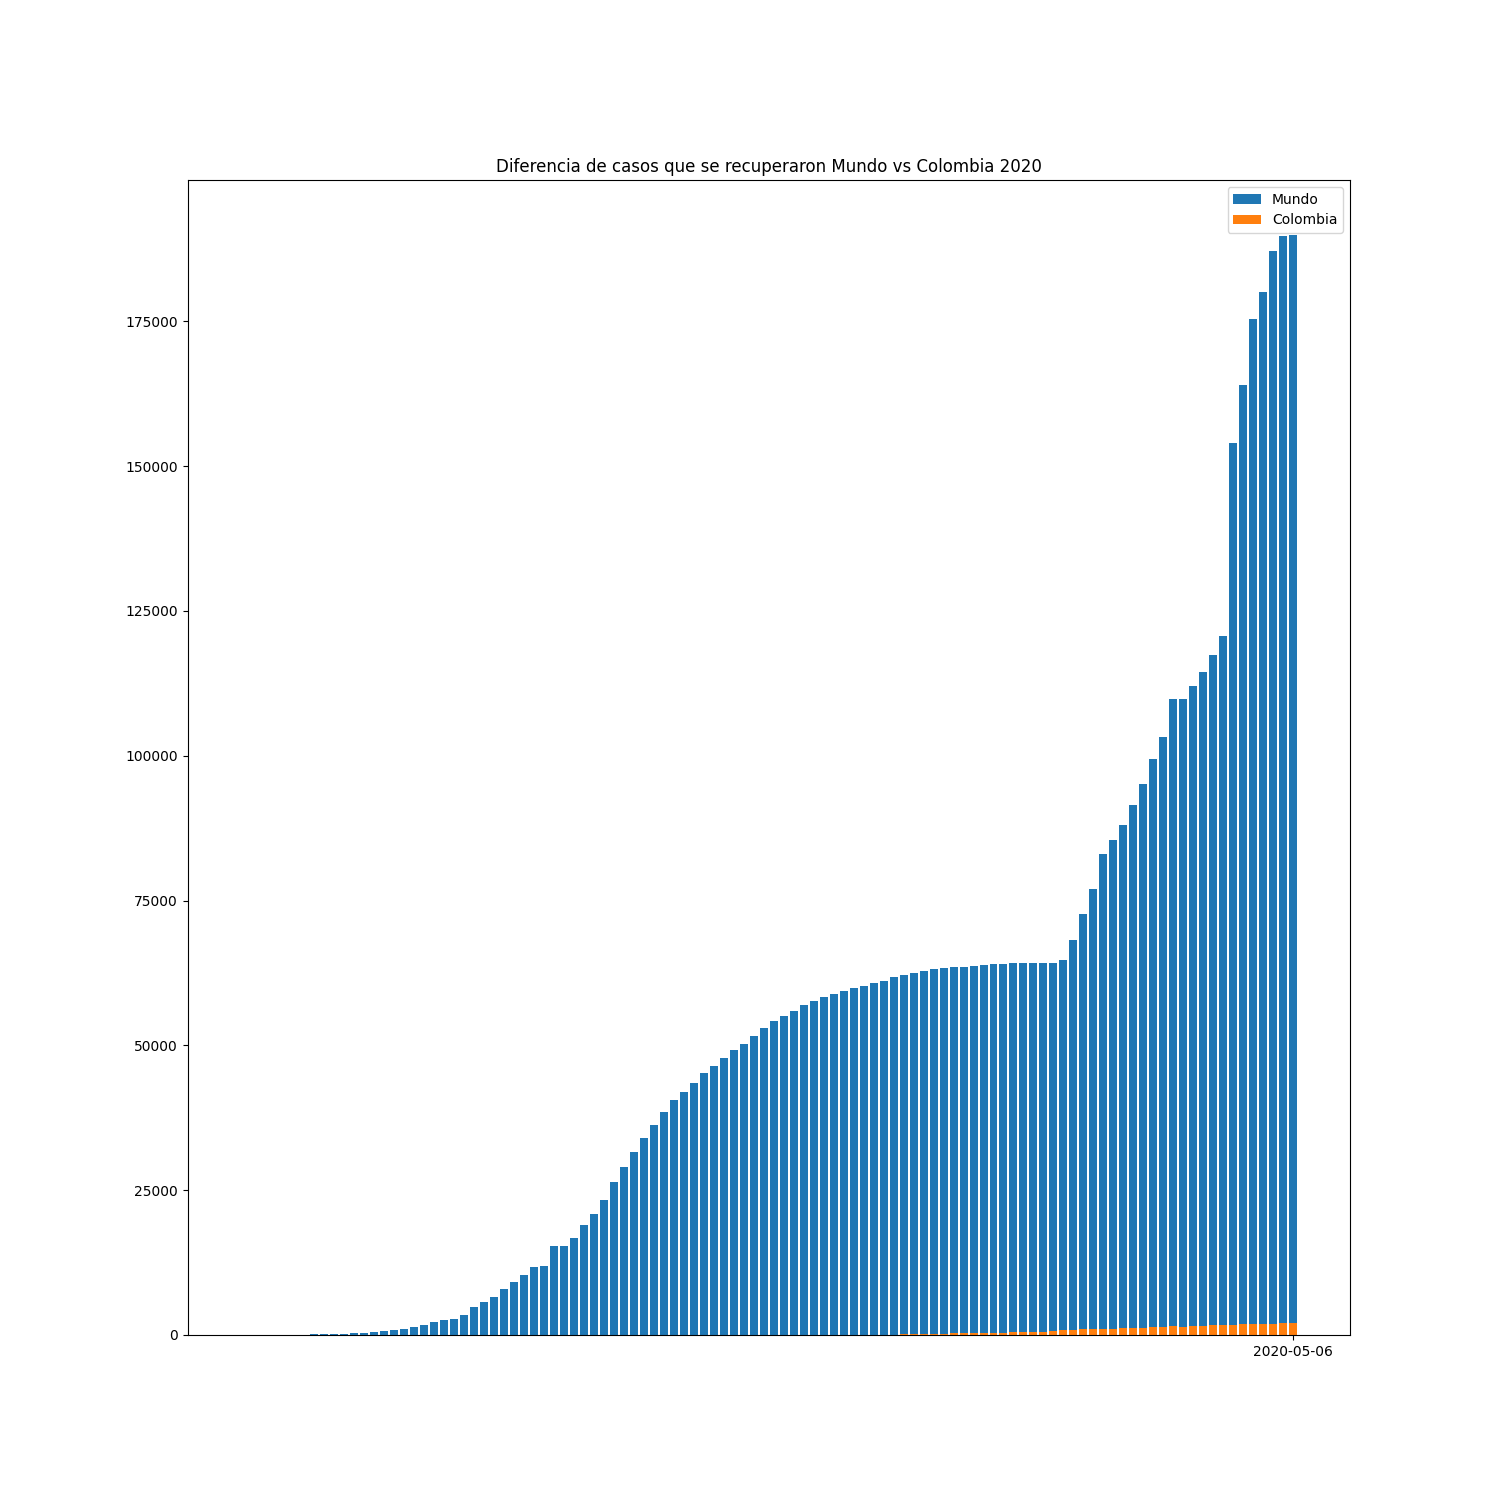

In [11]:
#Graficas comparativas del progreso de casos de muerte

fig5, ax5 = plt.subplots(figsize=(15,15))

progressCases = df_recovered.withColumn("Value", col("Value").cast("int")).groupBy("Date").agg(max_("Value")).orderBy('max(Value)',ascending=True)
x = progressCases.toPandas()['Date'].values.tolist()
y = progressCases.toPandas()['max(Value)'].values.tolist()

acum = 0

infection_progress = df_colombia.groupBy('Fecha recuperado').count().orderBy('Fecha recuperado',ascending=True)
x2 = infection_progress.toPandas()['Fecha recuperado'].values.tolist()
y2 = infection_progress.toPandas()['count'].values.tolist()

#Quitamos primeros datos atipicos
x2 = x2[3:]
y2 = y2[3:]

for e in range(len(y2)):
    if x2[e] is None:
        x2[e] = 'NA';
    else:
        x2[e] = x2[e][0:10]
    acum += y2[e]
    y2[e] = acum
    
length = int(len(y))
temp_y_colombia = [0]*length

for e in range(len(x)):
    if x[e] in x2:
        ind = x2.index(x[e])
        temp_y_colombia[e] = y2[ind]
    else:
        temp_y_colombia[e] = 0
        
ax5.bar(x[1:],y[1:],label='Mundo')
ax5.bar(x[1:],temp_y_colombia[1:],label='Colombia')
ax5.set_xticks(x[-1:])
ax5.set_title('Diferencia de casos que se recuperaron Mundo vs Colombia 2020')
ax5.legend(loc="upper right")

%matplot plt